# Wczytanie i podstawowa eksploracja danych

In [8]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.data_loader import load_data, basic_info

# Wczytanie danych
df = load_data('../data/SMSSpamCollection')

# Podstawowe informacje
basic_info(df)

Pierwsze 5 wiadomości:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Statystyki labeli:
label
ham     4825
spam     747
Name: count, dtype: int64

Informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


# Przygotowanie danych do trenowania modelu

In [9]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from src.data_loader import load_data
from src.preprocessing import preprocess_messages
from src.feature_extraction import vectorize_messages

# Wczytanie danych
df = load_data('../data/SMSSpamCollection')

# Preprocessing
df = preprocess_messages(df)

# Wektoryzacja
X, vectorizer = vectorize_messages(df["message"])

# Konwersja labeli: spam = 1, ham = 0
y = df["label"].apply(lambda x: 1 if x == "spam" else 0)

X.shape, y.shape

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hstryjewska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hstryjewska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


((5572, 37472), (5572,))

In [10]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hstryjewska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#  Trenowanie i optymalizacja modelu Naive Bayes

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definicja modelu
nb = MultinomialNB()

# Parametry do GridSearch
param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

# GridSearchCV - szukanie najlepszego alpha
grid = GridSearchCV(nb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Najlepsze parametry
print("Najlepsze alpha:", grid.best_params_)

# Predykcje na zbiorze testowym
y_pred = grid.predict(X_test)

# Ewaluacja
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Najlepsze alpha: {'alpha': 5.0}

Accuracy: 0.9811659192825112

Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Confusion matrix:
 [[964   2]
 [ 19 130]]


# Model alternatywny: XGBoost Classifier

In [12]:
# TRAINING: XGBoost Classifier
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost – Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))

/opt/homebrew/Caskroom/miniconda/base/envs/ai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:19:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost – Accuracy: 0.97847533632287

Classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion matrix:
 [[962   4]
 [ 20 129]]


# Zapisanie modeli

In [ ]:
import joblib

# Zapisz modele
joblib.dump(grid.best_estimator_, '../models/spam_classifier_model.joblib')
joblib.dump(xgb_model, '../models/spam_classifier_xgb_model.joblib')

# Zapisz vectorizer
joblib.dump(vectorizer, '../models/vectorizer.joblib')

['../models/vectorizer.joblib']

# Porównanie modeli

In [14]:
print("Porównanie dokładności modeli:")
print("Naive Bayes:", accuracy_score(y_test, y_pred))
print("XGBoost:", accuracy_score(y_test, y_pred_xgb))

Porównanie dokładności modeli:
Naive Bayes: 0.9811659192825112
XGBoost: 0.97847533632287


# Predykcja nowych wiadomości przy użyciu zapisanego modelu

In [15]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.predict import load_model_and_vectorizer, predict_message

# ladowanie modelu i vectorizer
model, vectorizer = load_model_and_vectorizer()

# Przykładowe predykcje
print(predict_message("Congratulations! You have won a free iPhone!", model, vectorizer))
print(predict_message("Hi, are we meeting at 5 pm today?", model, vectorizer))
print(predict_message("Win 1000$ cash now!", model, vectorizer))

Spam
Ham
Spam


Matplotlib is building the font cache; this may take a moment.


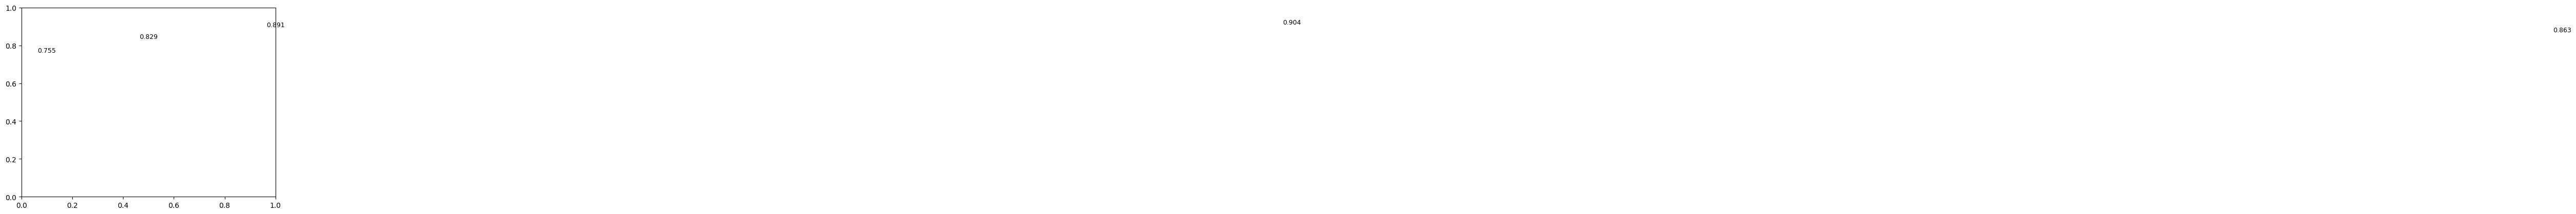

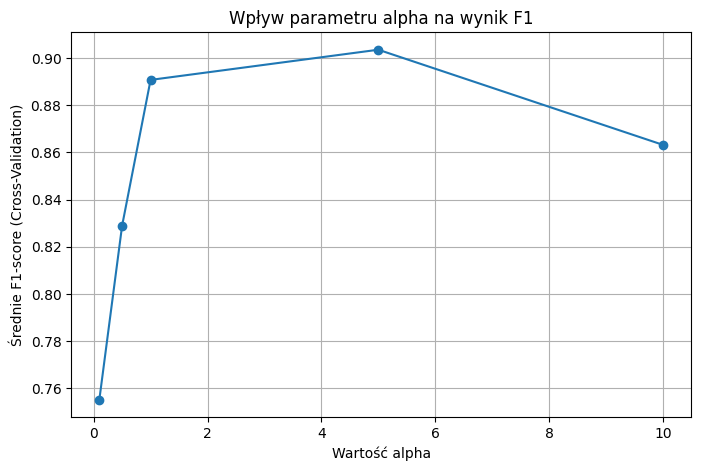

In [19]:
import matplotlib.pyplot as plt

# Sprawdzane wartości alpha
alpha_values = [0.1, 0.5, 1.0, 5.0, 10.0]

# Wyniki F1 score z GridSearchCV dla każdej wartości alpha
mean_test_scores = grid.cv_results_['mean_test_score']

for x, y in zip(alpha_values, mean_test_scores):
    plt.text(x, y, f'{y:.3f}', fontsize=9, ha='center', va='bottom')

# Rysowanie wykresu
plt.figure(figsize=(8,5))
plt.plot(alpha_values, mean_test_scores, marker='o')
plt.title('Wpływ parametru alpha na wynik F1')
plt.xlabel('Wartość alpha')
plt.ylabel('Średnie F1-score (Cross-Validation)')
plt.grid(True)
plt.show()